## **<font color="#A41034">Setup Notebook</font>**

**Installs**

In [3]:
!pip install -q wandb

**Imports**

In [4]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

# Dask
import dask
import dask.dataframe as dd
import dask.delayed as delayed
from dask.diagnostics import ProgressBar

**Verify Setup**

In [5]:
print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.13.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## **<font color="#A41034">Dataset</font>**

### **Download**

In [8]:
# cell to connect to our GCP Bucket
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gcloud config set project csci-115-398800

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

In [11]:
!mkdir snap_nutrition_data
!gcsfuse --implicit-dirs snapnutrition_data_bucket snap_nutrition_data
!gcsfuse --implicit-dirs snapnutrition_data_bucket/raw_data/Nutrition5k_realsense_overhead snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead

{"time":"07/10/2023 01:21:37.312081","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snap_nutrition_data\n"}
{"time":"07/10/2023 01:21:37.614192","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead\n"}
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithStorageHandle: fs.NewServer: create file system: SetUpBucket: Error in iterating through objects: storage: bucket doesn't exist


### **Load and Process Data**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [12]:
dishes_dir = "/content/snap_nutrition_data/data/raw_data/Nutrition5k/"
labels_dir = "/content/snap_nutrition_data/data/processed_labels/full_cleaned_dish_labels.csv"

In [13]:
dish_image_names = os.listdir(dishes_dir)
print(len(dish_image_names))
dish_image_names[:5]

3260


['dish_1556572657.png',
 'dish_1556573514.png',
 'dish_1556575014.png',
 'dish_1556575083.png',
 'dish_1556575124.png']

In [14]:
dish_image_names_stripped = [str.split(i, '.')[0] for i in dish_image_names]
dish_image_names_stripped[:5]

['dish_1556572657',
 'dish_1556573514',
 'dish_1556575014',
 'dish_1556575083',
 'dish_1556575124']

In [15]:
labels = pd.read_csv(labels_dir, index_col = 0)
print(labels.shape)

# subset labels df
labels = labels[labels['dish_id'].isin(dish_image_names_stripped)]
print(labels.shape)

# order labels df in same order as dish_images
labels = labels.set_index('dish_id')
labels = labels.reindex(dish_image_names_stripped)
labels.head()

(4766, 6)
(3260, 6)


,total_calories,total_mass,total_fat,total_carb,total_protein
dish_id,,,,,
dish_1556572657,41.399998,36.0,3.852,2.268,0.288
dish_1556573514,6.440000,23.0,0.092,1.219,0.506
dish_1556575014,71.299995,62.0,6.634,3.906,0.496
dish_1556575083,27.520000,64.0,0.192,5.760,2.176
dish_1556575124,4.480000,28.0,0.056,0.952,0.196


In [16]:
# Generate a list of labels and path to images

## create label names (list of lists)
label_names = []
for index, row in labels.iterrows():
    label_names.append(row.tolist())

## create list of file paths to images
file_names = []
for image_name in dish_image_names:
  file_names.append(os.path.join(dishes_dir, image_name))

print('label_names: ', label_names[:5])
print('file_names: ', file_names[:5])

## create final data_list
data_list = list(zip(label_names, file_names))
data_list[:5]

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

label_names:  [[41.399998, 36.0, 3.852, 2.268, 0.288], [6.44, 23.0, 0.092, 1.219, 0.506], [71.299995, 62.0, 6.634, 3.906, 0.496], [27.52, 64.0, 0.192, 5.76, 2.176], [4.48, 28.0, 0.056, 0.952, 0.196]]
file_names:  ['/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556572657.png', '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556573514.png', '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556575014.png', '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556575083.png', '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556575124.png']
Full size of the dataset: 3260
data_list: [([41.399998, 36.0, 3.852, 2.268, 0.288], '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556572657.png'), ([6.44, 23.0, 0.092, 1.219, 0.506], '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556573514.png'), ([71.299995, 62.0, 6.634, 3.906, 0.496], '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556575014.png')

### **View Images**

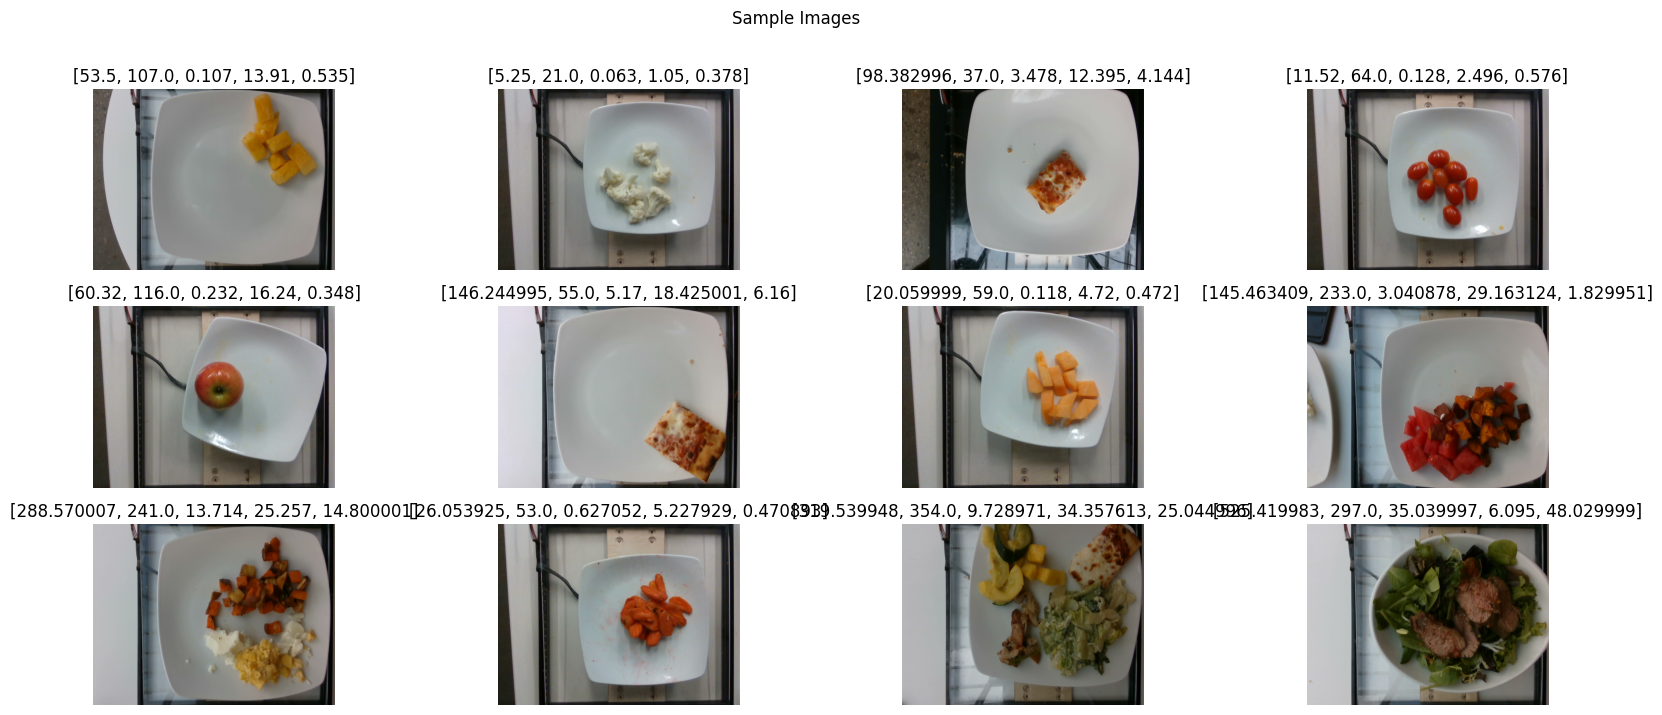

In [17]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### **Compute dataset metrics with dask**

In [18]:
# Get a list of paths to all images
image_files = glob('/content/snap_nutrition_data/data/raw_data/Nutrition5k/**')
print("Number of file:",len(image_files))

Number of file: 3260


In [19]:
image_width = 180
image_height = 180
num_channels = 3

@dask.delayed
def read_resize_image(file_path):
  # read image
  image = cv2.imread(file_path)
  # convert to rgb
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Resize image
  image = cv2.resize(image, (image_width,image_height), interpolation = cv2.INTER_AREA)

  return image

In [20]:
lazy_loaded_images = [read_resize_image(path) for path in image_files]

image_arrays = [dask.array.from_delayed(img,dtype=np.uint8,shape=(image_height, image_width, num_channels)) for img in lazy_loaded_images]
all_images_dask = dask.array.stack(image_arrays, axis=0)

lazy_loaded_images[0:2]

[Delayed('read_resize_image-41521217-a830-4f1b-a5c7-08de787dba17'),
 Delayed('read_resize_image-9b200c14-b682-4184-8234-05be31e4e451')]

In [21]:
all_images_dask

dask.array<stack, shape=(3260, 180, 180, 3), dtype=uint8, chunksize=(1, 180, 180, 3), chunktype=numpy.ndarray>

In [67]:
start_time = time.time()
dask_metrics = {}

mean, stdev = dask.compute(all_images_dask.mean(axis=(0,1, 2)), all_images_dask.std(axis=(0,1, 2)))
print("mean:", mean)
print("stdev:", stdev)

dask_metrics["mean"] = mean
dask_metrics["stdev"] = stdev
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

mean: [124.21070824 119.90607463 111.59685301]
stdev: [56.04240591 59.54450793 66.2541508 ]
Execution time (mins) 32.73140453497569


## **<font color="#A41034">Build Data Pipelines</font>**

### **Load X & Y**

Generate data_x and data_y

In [24]:
# Build data x, y
data_x = [itm[1] for itm in data_list]
data_y = [itm[0] for itm in data_list]
#data_y = [inner_list[0] for inner_list in data_y]

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_x: 3260
data_y: 3260
data_x: ['/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556572657.png', '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556573514.png', '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556575014.png', '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556575083.png', '/content/snap_nutrition_data/data/raw_data/Nutrition5k/dish_1556575124.png']
data_y: [[41.399998, 36.0, 3.852, 2.268, 0.288], [6.44, 23.0, 0.092, 1.219, 0.506], [71.299995, 62.0, 6.634, 3.906, 0.496], [27.52, 64.0, 0.192, 5.76, 2.176], [4.48, 28.0, 0.056, 0.952, 0.196]]


### **Split Data**
We split data into test, validation, & train

In [25]:
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 2640
validate_x count: 294
test_x count: 326


### **Create TF Datasets with custom dask normalizations**

In [27]:
def get_dataset(dask_metrics, image_width = 224, image_height = 224, num_channels = 3, batch_size = 32):

  # Load Image
  def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image, [image_height,image_width])
    return image, label

  # Normalize pixels
  def normalize(image, label):
    image = image/255
    return image, label

  # NORMALIZE USING DASK
  def custom_normalize(image, label, dask_metrics):
    image = (image - dask_metrics['mean']) / dask_metrics['stdev']
    return image, label

  train_shuffle_buffer_size= len(train_x)
  validation_shuffle_buffer_size= len(validate_x)

  # Create TF Dataset
  train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
  validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_y))
  test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y))

  #############
  # Train data
  #############
  # Apply all data processing logic
  train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
  train_data = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  train_data = train_data.map(custom_normalize, num_parallel_calls=tf.data.AUTOTUNE)
  train_data = train_data.batch(batch_size)
  train_data = train_data.prefetch(tf.data.AUTOTUNE)

  ##################
  # Validation data
  ##################
  # Apply all data processing logic
  validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
  validation_data = validation_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  validation_data = validation_data.map(custom_normalize, num_parallel_calls=tf.data.AUTOTUNE)
  validation_data = validation_data.batch(batch_size)
  validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

  ############
  # Test data
  ############
  # Apply all data processing logic
  test_data = test_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  test_data = test_data.map(custom_normalize, num_parallel_calls=tf.data.AUTOTUNE)
  test_data = test_data.batch(batch_size)
  test_data = test_data.prefetch(tf.data.AUTOTUNE)

  return (
      train_data, validation_data, test_data
  )

## **<font color="#A41034">Image Classificaton Models</font>**

### **Experiment Tracking**

Login to WandB to keep track of models. If you do not have an account signup in [WandB](https://wandb.ai/) to create a account for model tracking

In [28]:
# Login to W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Brent's Model**

In [20]:
def build_model(
    input_shape=(180, 180, 3),
    n_classes=5,
    n_filters=16,
    dense_nodes=256,
    conv_dropout=0.25,
    dense_dropout=0.5,
    filter_size=(3,3),
    pool_size=(2,2),
    output_activation='linear',
    model_name='model_brent'
    ):

    """
    This function builds a simplified vgg-like convolutional model

    """
    model = Sequential(
        [
            Conv2D(
                n_filters, filter_size, padding="same", activation="relu",
                input_shape=input_shape,
            ),
            Conv2D(n_filters, filter_size, padding="same", activation="relu"),
            MaxPooling2D(pool_size=pool_size),
            Dropout(conv_dropout),

            Conv2D(n_filters*2, filter_size, padding="same", activation="relu"),
            Conv2D(n_filters*2, filter_size, padding="same", activation="relu"),
            MaxPooling2D(pool_size=pool_size),
            Dropout(conv_dropout),

            Conv2D(n_filters*4, filter_size, padding="same", activation="relu"),
            Conv2D(n_filters*4, filter_size, padding="same", activation="relu"),
            MaxPooling2D(pool_size=pool_size),
            Dropout(conv_dropout),

            Conv2D(n_filters*8, filter_size, padding="same", activation="relu"),
            Conv2D(n_filters*8, filter_size, padding="same", activation="relu"),
            MaxPooling2D(pool_size=pool_size),
            Dropout(conv_dropout),

            Conv2D(n_filters*8, filter_size, padding="same", activation="relu"),
            Conv2D(n_filters*8, filter_size, padding="same", activation="relu"),
            MaxPooling2D(pool_size=pool_size),
            Dropout(conv_dropout),

            Flatten(),
            Dense(dense_nodes, activation="relu"),
            Dropout(dense_dropout),
            Dense(n_classes, activation=output_activation),
        ],
        name=model_name
    )

    return model

In [22]:
############################
# Training Params
############################
model_name = "model_brent"
learning_rate = 0.001
image_width = 180
image_height = 180
num_channels = 3
input_shape = (image_height, image_width, num_channels),
n_classes = 5,
batch_size = 128
epochs = 5

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_model()
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Initialize a W&B run
wandb.init(
    project = 'snap-nutrition',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model.name
    },
    name = model.name
)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

Model: "model_brent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                       

Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 995.7172 - accuracy: 0.0318 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_183256-8jaj31hk/files/model-best)... Done. 0.0s


21/21 [==============================] - 159s 8s/step - loss: 995.7172 - accuracy: 0.0318 - val_loss: 615.9742 - val_accuracy: 0.0000e+00
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 470.4431 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_183256-8jaj31hk/files/model-best)... Done. 0.0s


21/21 [==============================] - 86s 4s/step - loss: 470.4431 - accuracy: 0.0000e+00 - val_loss: 302.9316 - val_accuracy: 0.0000e+00
Epoch 3/5
21/21 [==============================] - 84s 4s/step - loss: 3941.2007 - accuracy: 0.0000e+00 - val_loss: 8361.0479 - val_accuracy: 0.0000e+00
Epoch 4/5
21/21 [==============================] - 76s 4s/step - loss: 6370.1411 - accuracy: 0.0000e+00 - val_loss: 8361.0479 - val_accuracy: 0.0000e+00
Epoch 5/5
21/21 [==============================] - 77s 4s/step - loss: 6972.2227 - accuracy: 0.0000e+00 - val_loss: 8361.0488 - val_accuracy: 0.0000e+00
Training execution time (mins) 9.158172706762949


accuracy,█▁▁▁▁
epoch,▁▃▅▆█
loss,▂▁▅▇█
val_accuracy,▁▁▁▁▁
val_loss,▁▁███
accuracy,0.0
best_epoch,1
best_val_loss,302.93164
epoch,4
loss,6972.22266
val_accuracy,0.0


### **MobileNet - Transfer Learning**

In [1]:
# Build Model
def build_mobilenet_model(image_height, image_width, num_channels, num_classes, model_name, train_base=False, weights='imagenet'):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Load a pretrained model from keras.applications
  tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights=weights, include_top=False)

  # Freeze the mobileNet model layers
  tranfer_model_base.trainable = train_base

  # added by me
  x = keras.layers.GlobalAveragePooling2D()(tranfer_model_base.output)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  output = tf.keras.layers.Dense(5, activation='linear')(x)  # 5 values

  model = tf.keras.models.Model(inputs=tranfer_model_base.input, outputs=output, name=model_name)

  return model

### **Train - Feature Extraction**

Freeze the base

In [ ]:
############################
# Training Params
############################
model_name = "mobilenetv2_deepika_custom_norm"
image_height = 180
image_width = 180
num_channels = 3
num_classes = 5,
weights = None # using DASK computed metrics
train_base = False
learning_rate = 0.001
batch_size = 128
epochs = 5

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size,
                                                     dask_metrics = dask_metrics)

# Model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, model_name, train_base, weights)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Initialize a W&B run
wandb.init(
    project = 'snap-nutrition',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model.name
    },
    name = model.name
)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

### **Train - Fine-Tuning**

Unfreeze the base

In [22]:
############################
# Training Params
############################
model_name = "mobilenetv2_deepika_train_base_custom_norm"
image_height = 180
image_width = 180
num_channels = 3
num_classes = 5,
weights = None # or 'imagenet'
train_base = True
learning_rate = 0.001
batch_size = 128
epochs = 5

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size,
                                                     dask_metrics = dask_metrics)

# Model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, model_name, train_base, weights)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Initialize a W&B run
wandb.init(
    project = 'snap-nutrition',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model.name
    },
    name = model.name
)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

9406464/9406464 [==============================] - 1s 0us/step


wandb: Currently logged in as: dey245 (snap-nutrition). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 25162.4473 - accuracy: 0.5511  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_193946-av291yas/files/model-best)... Done. 0.1s


21/21 [==============================] - 1508s 68s/step - loss: 25162.4473 - accuracy: 0.5511 - val_loss: 28718.3613 - val_accuracy: 0.5136
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 7702.0386 - accuracy: 0.5670 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_193946-av291yas/files/model-best)... Done. 0.1s


21/21 [==============================] - 653s 31s/step - loss: 7702.0386 - accuracy: 0.5670 - val_loss: 15766.6562 - val_accuracy: 0.5136
Epoch 3/5
21/21 [==============================] - 644s 31s/step - loss: 5518.1562 - accuracy: 0.5670 - val_loss: 95843.3516 - val_accuracy: 0.5136
Epoch 4/5
21/21 [==============================] - 648s 31s/step - loss: 4507.8413 - accuracy: 0.5670 - val_loss: 59420.7812 - val_accuracy: 0.5136
Epoch 5/5
21/21 [==============================] - 646s 31s/step - loss: 3801.5520 - accuracy: 0.5670 - val_loss: 93006.8672 - val_accuracy: 0.5136
Training execution time (mins) 68.91797250509262


accuracy,▁████
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▁▁▁▁
val_loss,▂▁█▅█
accuracy,0.56705
best_epoch,1
best_val_loss,15766.65625
epoch,4
loss,3801.552
val_accuracy,0.51361


## **<font color="#A41034">Download Model from WandB and Predict</font>**

In [29]:
# W&B Usage API
run = wandb.init()
artifact = run.use_artifact('snap-nutrition/snap-nutrition/model-mobilenetv2_deepika_train_base:v1', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: dey245 (snap-nutrition). Use `wandb login --relogin` to force relogin


wandb:   5 of 5 files downloaded.  


In [30]:
print("artifact_dir",artifact_dir)
# Load a model from artifact dir
prediction_model = tf.keras.models.load_model(artifact_dir)

prediction_model.summary()

artifact_dir ./artifacts/model-mobilenetv2_deepika_train_base:v1
Model: "mobilenetv2_deepika_train_base"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 90, 90, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 90, 90, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Con

### **Predict using model**

In [37]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(test_x)-1, size=12)
image_width = 180
image_height = 180
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]
# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = prediction_model.predict(prediction_data)
print("predictions.shape:",predictions.shape)
print(predictions[0],predictions[0].argmax())

fig = plt.figure(figsize=(40,30))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4,3,i+1)

    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # Actual label vs prediction
    prediction_label = predictions[i]
    axs.set_title("Actual:" + ' '.join([str(elem) for elem in test_y[img_idx]]) + ", Pred:" + ' '.join([str(elem) for elem in prediction_label]))


    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()

Output hidden; open in https://colab.research.google.com to view.